In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import scanpy as sc

In [3]:
DATASET_NAME = "LUNG-CITE"
BASE_DATA_DIR = os.path.join("..", "datasets", "data", "processed")  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from utils.data_utils import dataset_config, load_dataset

hetero_data, data_dict = load_dataset(DATASET_NAME, BASE_DATA_DIR, DEVICE)

c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to ..\datasets\data\processed\LUNG-CITE_processed.pt


Neighborhood Consistency Scores:
- ADT: 0.052
- RNA: 0.286


c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


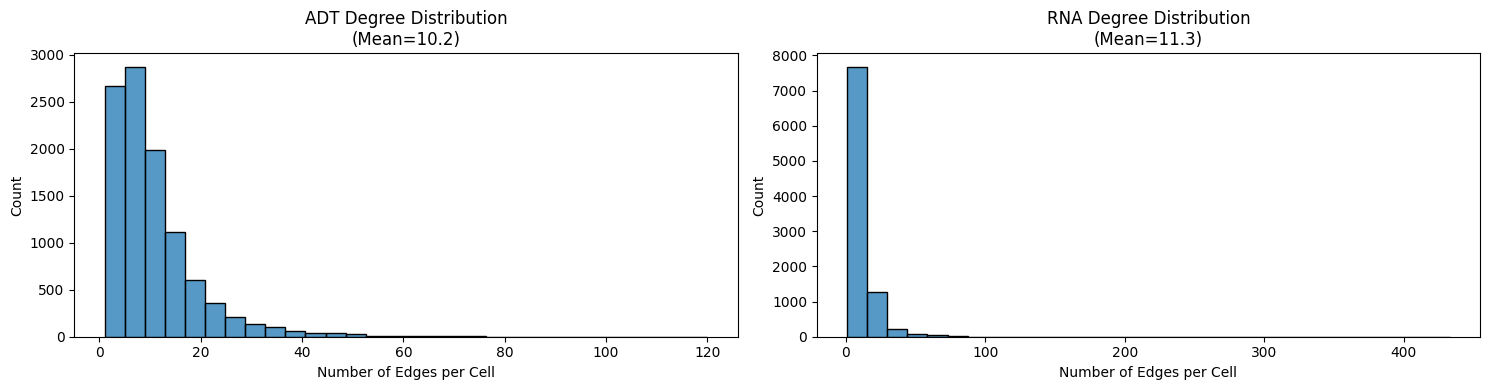

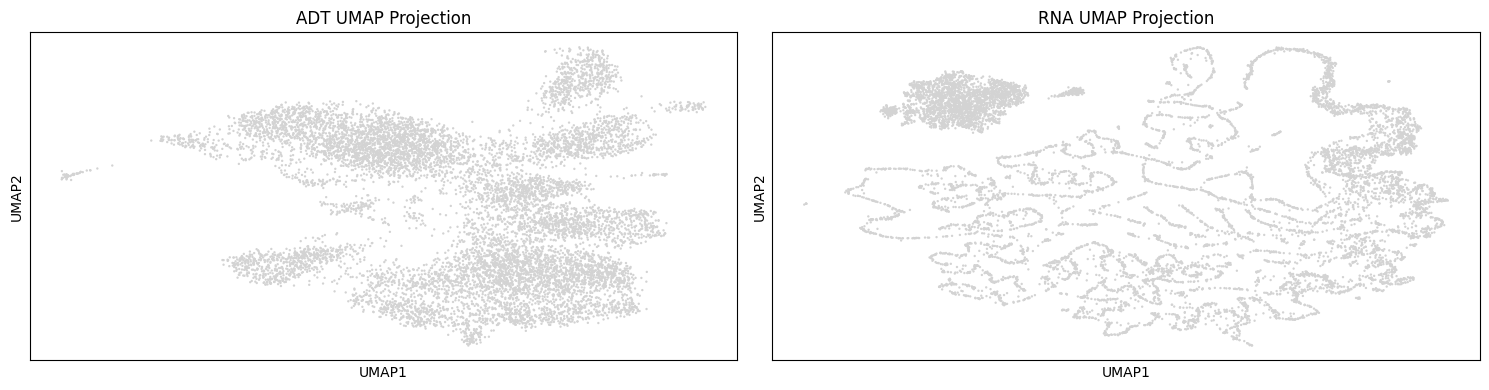

In [5]:
from utils.graph_utils import (
    calculate_modality_jaccard,
    plot_degree_distributions,
    plot_modality_umaps
)
import matplotlib.pyplot as plt

def visualize_individual_metrics(hetero_data, data_dict, config):
    """Visualize per-modality graph metrics using utils"""
    modalities = config["modalities"]
    
    # Calculate and print Jaccard scores
    jaccard_results = {
        m: calculate_modality_jaccard(hetero_data['cell', m, 'cell'].edge_index)
        for m in modalities
    }
    print("Neighborhood Consistency Scores:")
    for mod, score in jaccard_results.items():
        print(f"- {mod}: {score:.3f}")
    
    # Plot distributions
    degree_fig = plot_degree_distributions(hetero_data, modalities)
    umap_fig = plot_modality_umaps(data_dict, modalities)
    
    plt.show()

visualize_individual_metrics(hetero_data, data_dict, dataset_config[DATASET_NAME])

In [6]:
import torch
print(torch.__version__)          # e.g., 2.0.1
print(torch.version.cuda)         # e.g., 11.7 (or "None" for CPU-only)

2.5.1
12.4


In [7]:
import torch
print(torch.__version__)          # PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # CUDA version (e.g., 11.7)

2.5.1
True
12.4


In [10]:
import scanpy as sc

modalities = dataset_config[DATASET_NAME]["modalities"]
print(modalities)

data = {}

for modality in modalities:
    data[modality] = sc.read_h5ad(f"./../datasets/data/processed/{DATASET_NAME}_{modality}.h5ad")

data

['ADT', 'RNA']


{'ADT': AnnData object with n_obs × n_vars = 10470 × 52
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'count', 'percentile', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_apca'
     varm: 'APCA',
 'RNA': AnnData object with n_obs × n_vars = 10470 × 3000
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'group', 'volume', 'sampleID', 'celltype', 'nCount_ADT', 'nFeature_ADT'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_pca'
     varm: 'PCs'}

In [11]:
import torch

processed = {m: {'x': torch.tensor(data[m].X, dtype=torch.float)} for m in modalities}
processed

# processed = {m: {'x': torch.tensor(data[m].obsm['X_glue'], dtype=torch.float)} for m in modalities}
# processed - for the match data with precomputed latent representations

{'ADT': {'x': tensor([[-0.1067,  0.2336, -0.3761,  ...,  0.0417,  0.7129,  1.7810],
          [-0.0816,  0.6819,  0.1002,  ...,  2.8420,  0.1367, -0.2340],
          [ 0.1335, -0.1355, -0.0772,  ..., -0.8012, -0.0301, -0.7497],
          ...,
          [-0.2312,  0.4648,  0.3953,  ...,  0.1589, -0.9881,  0.5103],
          [-0.3114, -1.4292, -0.3896,  ...,  0.0273,  0.2220,  1.4590],
          [-0.4793,  0.5241, -1.0956,  ...,  0.8601, -0.9881,  0.5941]])},
 'RNA': {'x': tensor([[-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          ...,
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625,  6.1826, -0.0567],
          [-0.0301, -0.0906, -0.2151,  ..., -0.0625, -0.3316, -0.0567]])}}

In [12]:
from torch_geometric.data import HeteroData

# (1) Assign attributes after initialization,
data = HeteroData(processed)
data['cell'].x = torch.cat([data[m].x for m in modalities], dim=1)
data

HeteroData(
  ADT={ x=[10470, 52] },
  RNA={ x=[10470, 3000] },
  cell={ x=[10470, 3052] }
)

In [13]:
from torch_geometric.nn import knn_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

for m in modalities:
    data['cell', m, 'cell'].edge_index = knn_graph(
        data[m].x,
        k=10,
        cosine=True,
        num_workers=16
    )

In [14]:
data = data.cpu() 
output_path = os.path.join(os.path.join(BASE_DATA_DIR, DATASET_NAME), f"{DATASET_NAME}_processed.pt")
torch.save(data, output_path)
print(f"Saved processed data to {output_path}")

loaded_data = torch.load(output_path)
loaded_data = loaded_data.to(device)  # Move back to GPU if needed

Saved processed data to ..\datasets\data\processed\LUNG-CITE\LUNG-CITE_processed.pt


C:\Users\sonia\AppData\Local\Temp\ipykernel_18592\3593810440.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(output_path)


In [31]:
import torch
from torch_geometric.loader import NeighborLoader

# Assume 'data' is your HeteroData instance and the number of cell nodes is available via:
num_cells = data['cell'].x.size(0)  # or data['cell'].num_nodes if set

# Create indices for all cells:
cell_idx = torch.arange(num_cells)

neighbor_loader = NeighborLoader(
    data,
    num_neighbors={
        ('cell', m, 'cell'): [5, 5] for m in modalities
    },
    input_nodes=('cell', cell_idx),
    batch_size=64  # choose an appropriate batch size for your memory constraints
)

for batch in neighbor_loader:
    print(batch)

HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
  },
  RNA={
    x=[0, 3000],
    n_id=[0],
  },
  cell={
    x=[4139, 3052],
    n_id=[4139],
    input_id=[64],
    batch_size=64,
  },
  (cell, ADT, cell)={
    edge_index=[2, 3390],
    e_id=[3390],
  },
  (cell, RNA, cell)={
    edge_index=[2, 3390],
    e_id=[3390],
  }
)
HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
  },
  RNA={
    x=[0, 3000],
    n_id=[0],
  },
  cell={
    x=[4215, 3052],
    n_id=[4215],
    input_id=[64],
    batch_size=64,
  },
  (cell, ADT, cell)={
    edge_index=[2, 3345],
    e_id=[3345],
  },
  (cell, RNA, cell)={
    edge_index=[2, 3345],
    e_id=[3345],
  }
)
HeteroData(
  ADT={
    x=[0, 52],
    n_id=[0],
  },
  RNA={
    x=[0, 3000],
    n_id=[0],
  },
  cell={
    x=[4183, 3052],
    n_id=[4183],
    input_id=[64],
    batch_size=64,
  },
  (cell, ADT, cell)={
    edge_index=[2, 3360],
    e_id=[3360],
  },
  (cell, RNA, cell)={
    edge_index=[2, 3360],
    e_id=[3360],
  }
)
HeteroData(
  AD

In [32]:
from model import HeteroGraphAE, GraphAELightningModule

In [36]:
# Hyperparameters.
in_channels = hetero_data['cell'].x.size(1)
hidden_channels = 512
latent_channels = 256   # Dimensionality of the latent space.
num_layers = 2
learning_rate = 1e-3
n_epochs = 1 # change to 500 for full training

# Instantiate the Lightning module.
model = GraphAELightningModule(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    latent_channels=latent_channels,
    modalities=modalities,
    num_layers=num_layers,
    learning_rate=learning_rate,
    total_epochs=n_epochs,
    warmup_epochs=10,
    num_clusters=20,
    clustering_weight=.1
)

In [37]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',         # monitor your training loss
    dirpath='checkpoints',        # directory to save checkpoints
    filename='graph_ae-{epoch:02d}-{train_loss:.2f}',
    save_top_k=1,                 # save the best model
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='train_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)

trainer = Trainer(
    max_epochs=n_epochs,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)
trainer.fit(model, train_dataloaders=neighbor_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | model        | HeteroGraphAE | 1.7 M  | train
  | other params | n/a           | 5.1 K  | n/a  
-------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.736     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode
c:\Users\sonia\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have ma

Epoch 0:   0%|          | 0/164 [00:00<?, ?it/s] 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4111x3052 and 352x512)

In [ ]:
# Inference on full data:
model.eval()
with torch.no_grad():
    # Move data to the same device as the model.
    data = data.to(model.device)
    z = model(data)
    # For example, reconstruct edge probabilities using one set of edges.
    pos_edge_index = list(data.edge_index_dict.values())[0]
    pred_edge_probs = model.model.decode(z, pos_edge_index)
    print(f"nde_embedding: {z}")
    print("Predicted edge probabilities:", pred_edge_probs)


nde_embedding: tensor([[-3.4803e-02, -3.2477e-03,  2.3529e-02,  ..., -2.1730e-02,
          5.4659e-03, -1.9913e-02],
        [ 3.2221e-01,  7.0615e-01,  8.5208e-01,  ..., -4.5344e-02,
         -2.2416e-01, -4.6886e-01],
        [-2.1586e-02,  8.9226e-03, -1.4487e-03,  ...,  5.8153e-02,
          4.4665e-02, -1.6457e-03],
        ...,
        [ 5.6376e-02, -3.0002e-05,  5.6633e-02,  ..., -7.1382e-02,
         -5.5860e-02,  6.1703e-02],
        [-1.1818e-02,  3.9403e-03,  2.4603e-02,  ..., -2.3992e-02,
          1.4060e-03, -6.4563e-03],
        [ 4.0293e-02, -3.1938e-02,  4.0112e-02,  ..., -1.0683e-01,
         -3.6101e-02,  4.8252e-02]])
Predicted edge probabilities: tensor([0.5888, 0.5862, 0.5885,  ..., 0.6580, 0.6543, 0.6571])


In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, roc_auc_score, silhouette_score
from scipy.stats import pearsonr
from torch_geometric.utils import negative_sampling
import scanpy as sc
import anndata

# 1. Edge Reconstruction Metrics

# Combine all positive edges from 'cell'-to-'cell' relations.
pos_edge_list = []
for key, edge_index in data.edge_index_dict.items():
    if key[0] == 'cell' and key[2] == 'cell':
        pos_edge_list.append(edge_index)
if len(pos_edge_list) == 0:
    raise ValueError("No 'cell'-to-'cell' edges found in data.edge_index_dict.")
pos_edge_index = torch.cat(pos_edge_list, dim=1)

# Sample an equal number of negative edges.
neg_edge_index = negative_sampling(
    edge_index=pos_edge_index,
    num_nodes=z.size(0),
    num_neg_samples=pos_edge_index.size(1)
)

# Decode probabilities for positive and negative edges.
pos_pred = model.model.decode(z, pos_edge_index)  # predicted probabilities for true edges
neg_pred = model.model.decode(z, neg_edge_index)  # predicted probabilities for false edges

# Combine predictions and assign true labels: 1 for positive, 0 for negative.
predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy()
labels = np.concatenate([np.ones(pos_pred.size(0)), np.zeros(neg_pred.size(0))])

# RMSE: Lower is better.
rmse = np.sqrt(mean_squared_error(labels, predictions))
# PCC: +1 means perfect positive correlation.
pcc, _ = pearsonr(labels, predictions)
# AUROC: 0.5 means random guessing; 1.0 means perfect discrimination.
auroc = roc_auc_score(labels, predictions)

print("Edge Reconstruction Metrics:")
print("RMSE:", rmse)
print("PCC:", pcc)
print("AUROC:", auroc)


Edge Reconstruction Metrics:
RMSE: 0.4480434402017821
PCC: 0.4754248456238675
AUROC: 0.8875491672208493


In [ ]:
# Create an AnnData object from the latent embeddings.
adata_latent = anndata.AnnData(z.detach().cpu().numpy())
# Compute neighbors and run Louvain clustering.
sc.pp.neighbors(adata_latent, use_rep='X')
sc.tl.louvain(adata_latent, resolution=0.5)
pred_clusters = adata_latent.obs['louvain']

# ASW
asw = silhouette_score(z.detach().cpu().numpy(), pred_clusters.astype(int))
print("ASW (Average Silhouette Width):", asw)

ASW (Average Silhouette Width): 0.29114187


In [ ]:
import os
import pandas as pd

metrics_dict = {
    "Dataset": "BM-CITE",
    "RMSE": rmse,
    "PCC": pcc,
    "AUROC": auroc,
    "ASW": asw
}

# Convert to a DataFrame for easy CSV writing
df_metrics = pd.DataFrame([metrics_dict])

# Append to a master CSV for all datasets
csv_path = "all_metrics.csv"
# If the file doesn't exist, write headers. Otherwise, append without headers.
df_metrics.to_csv(
    csv_path, 
    mode='a', 
    header=not os.path.exists(csv_path), 
    index=False
)
print(f"Metrics saved to {csv_path}!")


Metrics saved to all_metrics.csv!


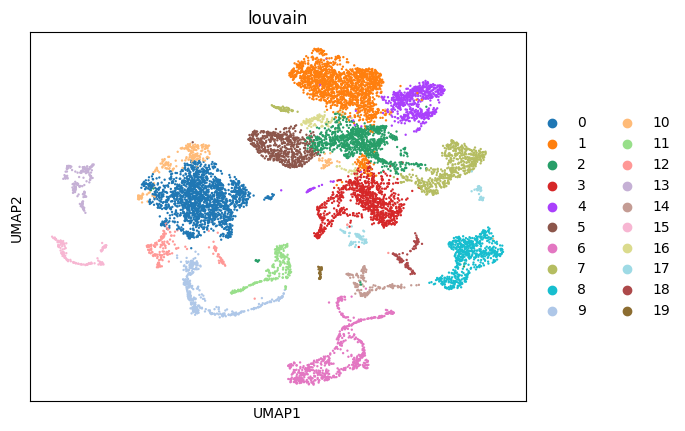

In [ ]:
# Set Scanpy's figure directory
import scanpy as sc
sc.settings.figdir = "./../figures/our_model"

protein_data.obsm["emb"] = z.detach().cpu().numpy()
sc.pl.umap(protein_data, color='louvain', save="_BM_CITE.png")